# Imports, spark init, dataset read

In [89]:
from pyspark.sql import SparkSession

import numpy as np
from pyspark.sql.functions import col, explode, array, lit
import plotly.graph_objects as go
import pyspark.sql.functions as sql_func
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, FloatType, BooleanType
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.ml.regression import GeneralizedLinearRegression, LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, FeatureHasher
seed = 777

In [90]:
def init_spark():
    spark = SparkSession \
        .builder \
        .master('local[*]')\
        .appName("Python Spark SQL basic example") \
        .config("spark.driver.memory", "15g")\
        .getOrCreate()
    return spark

We do not need 'Country' column, since it only has one value, it is clear we work in the scope of USA, 
'id' provides no relevant information either, so can be dropped

We also add a year column to easily distinguish on when the specific accdent occured

In [91]:
def read_dataset(filename):
    spark = init_spark()
    total_accidents_data = spark.read.csv(filename, header=True, mode="DROPMALFORMED", encoding="ISO-8859-1", inferSchema=True)
    # dropped meaningless and 1 class only columns
    final_result = total_accidents_data.drop('Country').drop('id')\
        .withColumn('start_year', sql_func.date_format(total_accidents_data.Start_Time, 'y'))
      
    return final_result

In [116]:
root_accidents_data = read_dataset('data/US_Accidents_Dec20.csv')
root_accidents_data.printSchema()

root
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doub

To reflect on the above output:
TMC - is the accident code assigned by the authorities full list can be found here:
https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List

In [93]:
# Total dataset count is:
root_accidents_data.count()

4232541

# Data analysis and cleanup, imbalance treatment, feature engineering

### Data source and meta

In [94]:
# we will use these functions to display a pie chart of a column
def display_piechart_of_column(accidents_dataframe: DataFrame, column_name: str):
    counted_accidents = accidents_dataframe.withColumn(column_name, col(column_name).cast('string'))\
        .groupBy(column_name).count()
        
    counted_accidents = counted_accidents.collect()
    labels = [label[column_name] for label in counted_accidents]
    counts = [label['count'] for label in counted_accidents]
    count_sum = reduce(lambda x, y: x + y, counts)
    percentages = [count/count_sum for count in counts]
    piechart(labels, percentages, column_name)
    zipped = [(labels[i], counts[i]) for i in range(len(labels))]
    print(zipped)


def piechart(labels, percentages, column_name):
    plt.pie(percentages, labels=labels)
    plt.title(f'ratio by {column_name}')
    plt.show()

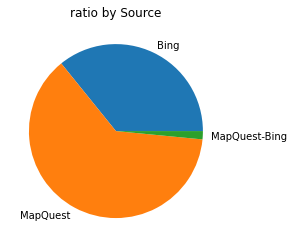

[('Bing', 1516064), ('MapQuest', 2651861), ('MapQuest-Bing', 64616)]


In [95]:
display_piechart_of_column(root_accidents_data, 'Source')

As can be seen above the data comes from 3 sources: MapQuest, Bing, and a mix up of MapQuest-Bing. There are about twice as many inputs from MapQuest compared to Bing

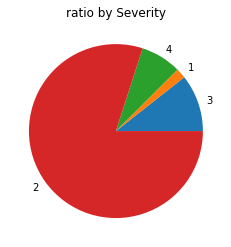

[('3', 161052), ('1', 28178), ('4', 114452), ('2', 1212382)]


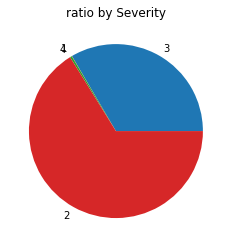

[('3', 886933), ('1', 1115), ('4', 9269), ('2', 1754544)]


In [96]:
bing = root_accidents_data.filter(col('Source') == 'Bing')
display_piechart_of_column(bing, 'Severity')

quest = root_accidents_data.filter(col('Source') == 'MapQuest')
display_piechart_of_column(quest, 'Severity')

as can be seen above, Bing and MapQuest have recorded a different ratios of severities of each level, It looks like Map Quest have stricter requirements for level 4, and such a minority of them was recorded over 5 years. Bing's chart while biased towards severity 2 displays more coverage on other categories. We cannot use both datasets, and while it is hard to choose which one. #todo decide if should choose either or drop

wind analysis

us states analysis. Maybe just do regressions per state to reach better results since authorities mostly care about data within their state and not their neighbour's state


Outlier Treatment

In [97]:
root_accidents_data = root_accidents_data.withColumn('year', sql_func.date_format(root_accidents_data.Start_Time, 'y'))\
    .withColumn('year', col('year').cast(IntegerType()))
root_accidents_data = root_accidents_data.withColumn('month', sql_func.date_format(root_accidents_data.Start_Time, 'M'))\
    .withColumn('month', col('month').cast(IntegerType()))
root_accidents_data = root_accidents_data.withColumn('day', sql_func.date_format(root_accidents_data.Start_Time, 'd'))\
    .withColumn('day', col('day').cast(IntegerType()))
root_accidents_data = root_accidents_data.withColumn('hour_minutes', \
    sql_func.date_format(root_accidents_data.Start_Time, 'H')*60 + sql_func.date_format(root_accidents_data.Start_Time, 'm'))

### Accidents per day of the week

In [98]:
root_accidents_data = root_accidents_data.withColumn('weekday', sql_func.date_format(root_accidents_data.Start_Time, 'E'))

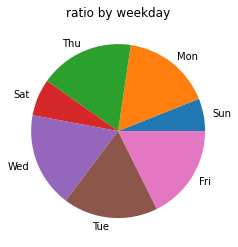

[('Sun', 255920), ('Mon', 703779), ('Thu', 742968), ('Sat', 289754), ('Wed', 747851), ('Tue', 744645), ('Fri', 747624)]


In [99]:
display_piechart_of_column(root_accidents_data, 'weekday')

As we can see on the chart above, accidents are much less frequent on the weekend as they are on the work days, therefore day of the week is an important feature for the classification Model

### Road condition, accident side, street location

#### Side

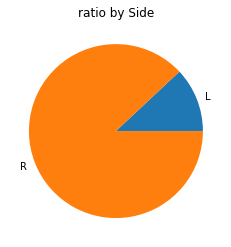

[('L', 62607), ('R', 460092)]


In [106]:
display_piechart_of_column(root_accidents_data, 'Side')

should we add bivariate/multivariate analysis?

separate EDA from data pre processing

### Weather Condition and Wind

#### Weather Condition

In [117]:
root_accidents_data.groupBy('Weather_Condition').count().orderBy('count').show(100)

+--------------------+-----+
|   Weather_Condition|count|
+--------------------+-----+
|         Heavy Smoke|    1|
|Thunder and Hail ...|    1|
| Partial Fog / Windy|    1|
|Widespread Dust /...|    1|
|Freezing Rain / W...|    1|
|       Sleet / Windy|    1|
|Sand / Dust Whirl...|    1|
|       Drifting Snow|    1|
|    Thunder and Hail|    1|
|         Dust Whirls|    1|
|        Mist / Windy|    1|
|        Blowing Sand|    1|
|    Snow and Thunder|    1|
|                Hail|    2|
|      Rain and Sleet|    2|
|Heavy Freezing Dr...|    2|
|Sand / Dust Whirl...|    2|
|        Snow Showers|    2|
|   Heavy Rain Shower|    3|
|             Tornado|    3|
|  Light Blowing Snow|    3|
|    Freezing Drizzle|    3|
|  Light Thunderstorm|    3|
|          Light Hail|    3|
|Thunderstorms and...|    3|
| Light Sleet / Windy|    4|
|  Heavy Blowing Snow|    4|
|         Snow Grains|    4|
|   Heavy Ice Pellets|    4|
|           Light Fog|    4|
|   Light Snow Shower|    5|
|   Low Drifti

Weather conditions are very diverse. We will try to divide them into categories and assign them

#### Visibility

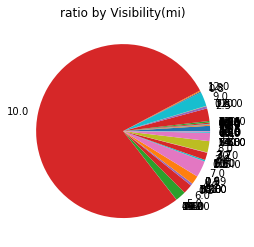

[('1.0', 41191), ('0.75', 6404), ('4.2', 10), ('50.0', 2146), ('75.0', 64), ('22.0', 4), ('90.0', 8), ('20.0', 3318), ('0.31', 1), ('15.0', 3400), ('45.0', 358), ('67.0', 1), ('47.0', 2), ('0.25', 9316), ('0.99', 8), ('0.7', 15), ('4.5', 1), ('63.0', 1), ('25.0', 535), ('0.06', 170), ('6.2', 2), ('120.0', 5), ('0.2', 12092), (None, 98668), ('2.5', 18479), ('72.0', 1), ('110.0', 1), ('1.6', 31), ('0.0', 2642), ('9.0', 111026), ('0.8', 8317), ('1.8', 8400), ('12.0', 366), ('10.0', 3292496), ('0.12', 694), ('3.5', 28), ('14.0', 6), ('46.0', 1), ('1.4', 35), ('19.0', 2), ('70.0', 266), ('111.0', 3), ('5.0', 83104), ('6.0', 73798), ('0.5', 17901), ('0.38', 116), ('101.0', 1), ('34.0', 2), ('35.0', 189), ('100.0', 14), ('58.0', 1), ('4.0', 66937), ('1.9', 44), ('0.9', 48), ('0.19', 8), ('0.6', 72), ('7.0', 128664), ('0.1', 1287), ('105.0', 1), ('1.5', 11325), ('2.8', 129), ('60.0', 195), ('11.0', 148), ('2.0', 57547), ('3.2', 1), ('2.2', 114), ('30.0', 3203), ('3.7', 2), ('8.0', 88559), ('54

In [118]:
display_piechart_of_column(root_accidents_data, 'Visibility(mi)')

visibility is mostly clear

Update wind direction property and map it to W if WNW for example
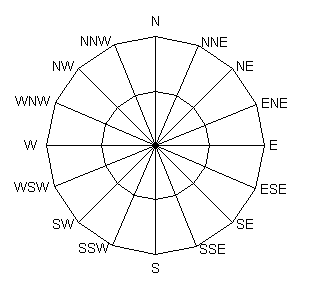

update weather conditions. If weather is calm then wind speed is 0 but it is null in the dataset

update wind values

### POI

drop description since POI are accessible via other columns

### States analysis

In [100]:
def build_states_graph(df):
    data = df.groupBy("State").count().filter(col('State') != 'null').collect()
    states = [row['State'] for row in data]
    state_counts = [row['count'] for row in data]

    fig = go.Figure(
        data=go.Choropleth(
            locations = states,
            z = state_counts,
            locationmode = 'USA-states',
            colorscale = 'SunsetDark',
            colorbar_title = "Count"),
        layout=go.Layout(
            title_text='US Accidents by State (Feb 2016—Dec 2020)',
            title_x=0.5,
            font=dict(family='Verdana', size=12, color='#000000'),
            geo_scope='usa'))

    fig.show()
    
build_states_graph(root_accidents_data)

Roads often get blocked for maintanance, there are a lot of unkown external factors besides all the given information. People in US states are also very different in their cultural values, mindsets. The problem of traffic is the most prevalent in California, as can be seen above so to make estimates more precise we will also filter by California State

In [101]:
root_accidents_data = root_accidents_data.filter(col('State') == 'CA').filter((col('year') == 2019) | ((col('year') == 2020)))
root_accidents_data.count()

522699

There is a clear dataset imbalance problem we have to deal with

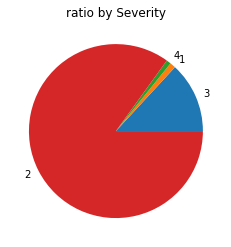

[('3', 68629), ('1', 5585), ('4', 4467), ('2', 444018)]


In [102]:
display_piechart_of_column(root_accidents_data, 'Severity')

'Severity' is largely dominated by class '2'. To solve this, we will oversample the minority classes and undersample majority.

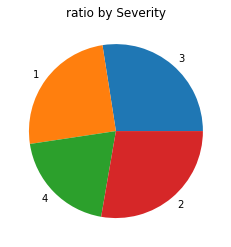

[('3', 61631), ('1', 55850), ('4', 44670), ('2', 62182)]


In [103]:
a = range(10)
sev_1 = root_accidents_data.filter(col('Severity') == 1).withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
sev_2 = root_accidents_data.filter(col('Severity') == 2).sample(0.14, seed)
sev_3 = root_accidents_data.filter(col('Severity') == 3).sample(0.9, seed)
sev_4 = root_accidents_data.filter(col('Severity') == 4).withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
balanced_dataset = sev_1.unionAll(sev_2).unionAll(sev_3).unionAll(sev_4)
#balanced_dataset = balanced_dataset.sampleBy('Severity', {1: 1.0, 2: 0.3, 3: 1.0, 4: 1.0}, seed=seed)
display_piechart_of_column(balanced_dataset, 'Severity')

Now the Severity class is much more balanced

# Modeling

In [104]:
def test_model(estimator, is_classification, dataframe, categorical_features, continuous_features, label_to_predict, seed):
    #only select specified columns for featurization
    dataframe = dataframe.select(label_to_predict, *categorical_features, *continuous_features).dropna()
    #featurize columns, convert categorical into vectors
    label_features_df = df_to_label_features(dataframe, label_to_predict, categorical_features, continuous_features)
    (training, test) = label_features_df.randomSplit([0.8, 0.2], seed)

    #train and fit
    model = estimator.fit(training)
    predictions_labels = model.transform(test)
    predictions_labels.show()

    #evaluate
    print_metrics(predictions_labels, is_classification)

#helper functions for regression/classification
def df_to_label_features(dataframe, label_to_predict, categorical_features, continuous_features):
    # stages = build_pipeline_stages(categorical_features, continuous_features)
    # pipelined_dataframe = pipeline_dataframe(stages, dataframe)
    hasher = FeatureHasher(inputCols=[*categorical_features, *continuous_features], outputCol='features')
    featurized = hasher.transform(dataframe)
    label_features = featurized.select(label_to_predict, 'features').withColumnRenamed(label_to_predict, 'label')
    return label_features



def print_metrics(predictions, is_classification):
    evaluator = None
    if is_classification:
        evaluator = MulticlassClassificationEvaluator()
        metrics = ['accuracy', 'f1']
    else:
        evaluator = RegressionEvaluator()
        metrics = ['rmse']
    for metric in metrics:
        evaluation = evaluator.evaluate(predictions, {evaluator.metricName: metric})
        print(f'{metric}: {evaluation}')
        

In [109]:
test_model(LogisticRegression(maxIter=100), True, balanced_dataset, \
           ['Weather_Condition', 'weekday'], ['hour_minutes', 'year', 'month', 'day'], 'Severity', seed)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(262144,[75181,84...|[-511.27435149462...|[6.05466659389700...|       2.0|
|    1|(262144,[75181,12...|[-511.27413984783...|[6.33084744599559...|       2.0|
|    1|(262144,[75181,12...|[-511.27413984783...|[6.33084744599559...|       2.0|
|    1|(262144,[75181,20...|[-511.27419477095...|[3.07362982870111...|       2.0|
|    1|(262144,[23406,75...|[-511.27399341889...|[6.22418878312961...|       1.0|
|    1|(262144,[23406,75...|[-511.27399341889...|[6.22418878312961...|       1.0|
|    1|(262144,[23406,75...|[-511.27399341889...|[6.22418878312961...|       1.0|
|    1|(262144,[52274,75...|[-511.27421705383...|[5.70784119559118...|       1.0|
|    1|(262144,[52274,75...|[-511.27421705383...|[5.70784119559118...|       1.0|
|    1|(262144,[

As we can see on the dataset below, providing Side, improves confidence of the model in the prediction, while the accuracy is about the smae, the f1 measure went up by 2%

In [119]:
test_model(LogisticRegression(maxIter=100), True, balanced_dataset, \
           ['Sunrise_Sunset', 'Weather_Condition', 'weekday', 'Side'], ['hour_minutes', 'year', 'month', 'day'], 'Severity', seed)

KeyboardInterrupt: 

In [121]:
test_model(LogisticRegression(maxIter=100), True, balanced_dataset, \
           ['Sunrise_Sunset', 'Weather_Condition', 'weekday', 'Side'], ['Start_Lat', 'Start_Lng', 'Visibility(mi)', 'hour_minutes', 'year', 'month', 'day'], 'Severity', seed)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(262144,[7263,281...|[-379.80477706348...|[8.23834851782601...|       3.0|
|    1|(262144,[28110,31...|[-379.80205204320...|[5.50490635887590...|       2.0|
|    1|(262144,[28110,31...|[-379.80205204320...|[5.50490635887590...|       2.0|
|    1|(262144,[28110,31...|[-379.80561415850...|[1.52646627274661...|       2.0|
|    1|(262144,[7263,281...|[-379.80209314764...|[1.08426739064464...|       4.0|
|    1|(262144,[7263,281...|[-379.80209314764...|[1.08426739064464...|       4.0|
|    1|(262144,[7263,281...|[-379.80209314764...|[1.08426739064464...|       4.0|
|    1|(262144,[7263,281...|[-379.80572472083...|[1.10042362072269...|       1.0|
|    1|(262144,[7263,281...|[-379.80572472083...|[1.10042362072269...|       1.0|
|    1|(262144,[